### Initialization
#### Notebook stuff

In [1]:
from IPython.display import display, Latex, HTML
display(HTML(open('01.css').read()))

#### Numpy and Scipy

In [2]:
import numpy as np
from numpy import array, cos, diag, eye, linspace, pi
from numpy import poly1d, sign, sin, sqrt, where, zeros
from scipy.linalg import eigh, inv, det

#### Matplotlib

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['figure.dpi'] = 115
plt.rcParams['figure.figsize'] = (7.5, 2.5)
plt.rcParams['axes.grid'] = True

#### Miscellaneous definitions

In the following `ld` and `pmat` are used to display mathematical formulas generated by the program, `rounder` ensures that a floating point number _close_ to an integer will be rounded correctly when formatted as an integer, `p` is a shorthand to calling `poly1d` that is long and requires a single argument, `vw` computes the virtual work done by moments `m` for the curvatures `c`, when the lengths of the beams are `l` and eventually
`p0_p1` given an array of values `p` returns first `p[0], p[1]` then `p[1], p[2]` then...

In [4]:
def ld(*items): 
    display(Latex('$$' + ' '.join(items) + '$$'))
def pmat(mat, env='bmatrix', fmt='%+f'):
    opener = '\\begin{'+env+'}\n  '
    closer = '\n\\end{'+env+'}'
    formatted = '\\\\\n  '.join('&'.join(fmt%elt for elt in row) for row in mat)
    return opener+formatted+closer
def rounder(mat): return mat+0.01*sign(mat)
def p(*l): return poly1d(l)
def vw(emme, chi, L):
    return sum(((m*c).integ()(l)-(m*c).integ()(0)) for (m, c, l) in zip(emme, chi, L))
def p0_p1(p):
    from itertools import tee
    a, b = tee(p)
    next(b, None)
    return zip(a, b)

# 3 DOF System

## Input motion

We need the imposed displacement, the imposed velocity (an intermediate result) and the imposed acceleration.  It is convenient to express these quantities in terms of an adimensional time coordinate $a = \omega_0 t$,

\begin{align}
   u        &= \frac{4/3\omega_0 t - \sin(4/3\omega_0 t)}{2\pi}
             = \frac{\lambda_0 a- \sin(\lambda_0 a)}{2\pi},\\
   \dot{u}  &= \frac{4}{3}\omega_0 \frac{1-\cos(4/3\omega_0t)}{2\pi}
             = \lambda_0 \omega_0 \frac{1-\cos(\lambda_0 a)}{2\pi},\\
   \ddot{u} &= \frac{16}{9}\omega_0^2 \frac{\sin(4/3\omega_0t)}{2\pi}
             = \lambda_0^2\omega_0^2 \frac{\sin(\lambda_0 a)}{2\pi},
\end{align}

with $\lambda_0=4/3$.

The equations above are valid in the interval 

$$ 0 \le t \le \frac{2\pi}{4/3 \omega_0} \rightarrow
   0 \le a \le \frac{3\pi}2 $$
   
(we have multiplied all terms by $\omega_0$ and simplified the last term).
Following a similar reasoning, the plotting interval is equal to $0\le a\le2\pi$.

In [5]:
l0 = 4/3
# define a function to get back the time array and the 3 dependent vars
def a_uA_vA_aA(t0, t1, npoints):
    a  = linspace(t0, t1, npoints)
    uA = where(a<3*pi/2, (l0*a-sin(l0*a))/2/pi, 1)
    vA = where(a<3*pi/2, (1-cos(l0*a))/2/pi, 0)
    aA = where(a<3*pi/2, 16*sin(l0*a)/18/pi, 0)
    return a, uA, vA, aA
# and use it
a, uA, vA, aA = a_uA_vA_aA(0, 2*pi, 501)

#### The plots

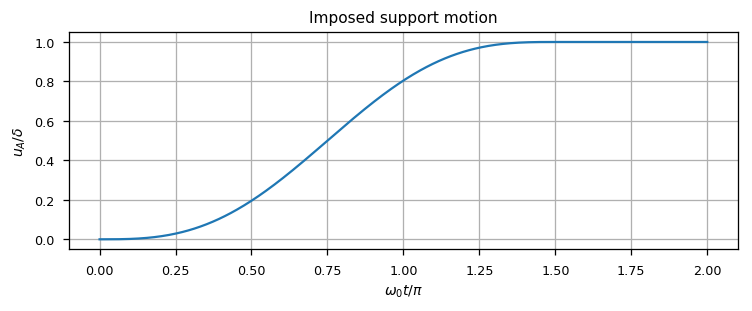

In [6]:

plt.plot(a/pi, uA)
plt.xlabel(r'$\omega_0 t/\pi$')
plt.ylabel(r'$u_A/\delta$')
plt.title('Imposed support motion');

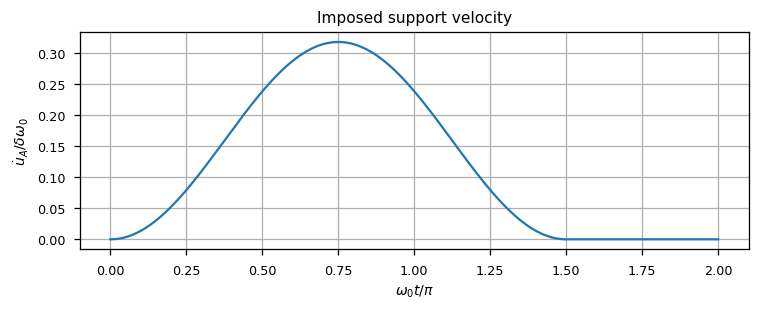

In [7]:
plt.plot(a/pi, vA)
plt.xlabel(r'$\omega_0 t/\pi$')
plt.ylabel(r'$\dot u_A/\delta\omega_0$')
plt.title('Imposed support velocity');

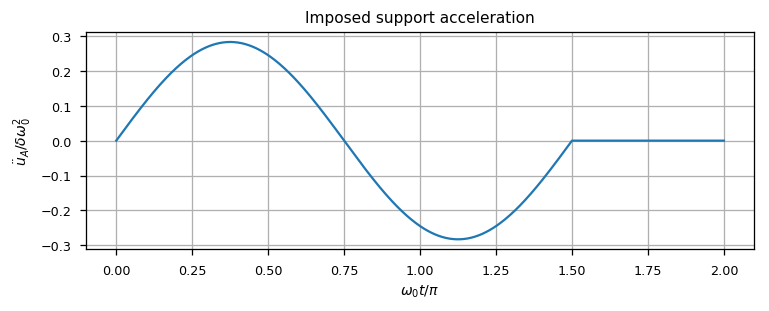

In [8]:
plt.plot(a/pi, aA)
plt.xlabel(r'$\omega_0 t/\pi$')
plt.ylabel(r'$\ddot u_A/\delta\omega_0^2$')
plt.title('Imposed support acceleration');

##  Equation of Motion

The EoM expressed in adimensional coordinates and using adimensional structural matrices is

$$ m\omega_0^2\hat{\boldsymbol M} \frac{\partial^2\boldsymbol x}{\partial a^2}
 + \frac{EJ}{L^3}\hat{\boldsymbol K}\boldsymbol x =
 m \hat{\boldsymbol M} \boldsymbol e \omega_0^2 \frac{\partial^2 u_A}{\partial a^2}
$$ 

using the dot notation to denote derivatives with respect to $a$, if we divide both members by $m\omega_0^2$ we have

$$ \hat{\boldsymbol M} \ddot{\boldsymbol x}
 + \hat{\boldsymbol K}\boldsymbol x =
 \hat{\boldsymbol M} \boldsymbol e \ddot{u}_A.
$$ 

We must determine the influence vector $\boldsymbol e$ and the adimensional structural matrices

### Influence vector

To impose a horizontal displacement in $A$ we must remove one constraint, so that the structure has 1 DOF as a rigid system and the influence vector must be determined by a kinematic analysis.

![](figures/trab1kin_conv.svg "Degrees of freedom")

The left beam is constrained by a roller and by the right beam, the first requires that the Centre of Instantaneous Rotation (CIR) belongs to the vertical line in $A$, while the second requires that the CIR belongs to the line that connects the hinges
of the right beam.

The angles of rotation are $\theta_\text{left} = u_A/L$ and $\theta_\text{right}
= -2 u_A/L$ and eventually we have $x_1=x_2=x_3=2u_A$ and

$$ \boldsymbol e = \begin{Bmatrix}2\\2\\2\end{Bmatrix}.$$

In [9]:
e = array((2.0, 2.0, 2.0))

### Structural Matrices

![](figures/trab1_conv.svg "Degrees of freedom")

Compute the 3x3 flexibility using the Principle of Virtual Displacements and the 3x3 stiffness using inversion, while the mass matrix is directly assembled with the understanding that the lumped mass on $x_1$ is $2m$.

The code uses a structure `m` where each of the three rows contains the 
computational represention (as polynomial coefficients) of the bending moments due to
a unit load applied in the position of each of the three degrees of freedom,
in each row six groups of polynomial coefficients, one group for each of the six
intervals of definition in which the structure has been subdivided (a possible seventh interval is omitted because the bending moment is always zero for every possible unit load).

In [10]:
l = [1, 2, 2, 1, 1, 1]
h = 0.5 ; t = 3*h
m = [[p(2,0),p(h,0),p(h,1),p(h,0),p(h,h),p(1,0)],
     [p(2,0),p(1,0),p(0,2),p(1,0),p(1,1),p(2,0)],
     [p(2,0),p(h,0),p(h,1),p(h,0),p(t,h),p(2,0)]]

F = array([[vw(emme, chi, l) for emme in m] for chi in m])
K = inv(F)
M = array(((2.0, 0.0, 0.0),
           (0.0, 1.0, 0.0),
           (0.0, 0.0, 1.0)))
iM = inv(M)

ld('\\boldsymbol F = \\frac{L^3}{12EJ}\\,', pmat(rounder(F*12), fmt='%+d'))
ld('\\boldsymbol K = \\frac{3 EJ}{1588L^3}\\,',
               pmat(rounder(K*1588/3), fmt='%+d'),
              '= \\frac{EJ}{L^3}\\;\\hat{\\boldsymbol K}.')
ld('\\boldsymbol M = m\\,', pmat(M, fmt='%d'),
              '= m\\;\\hat{\\boldsymbol M}.')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### The eigenvalues problem

We solve immediately the eigenvalue problem because when we know the shortest modal period of vibration it is possible to choose the integration time step $h$ to avoid numerical unstability issues with the linear acceleration algorithm.

In [11]:
wn2, Psi = eigh(K, M)
wn = sqrt(wn2)
li = wn
Lambda2 = diag(wn2)
Lambda = diag(wn)
# eigenvectors are normalized → M* is a unit matrix, as well as its inverse
Mstar, iMstar = eye(3), eye(3)

ld(r'\boldsymbol\Omega^2 = \omega_0^2\,', pmat(Lambda2),
   r'=\omega_0^2\,\boldsymbol\Lambda^2.')
ld(r'\boldsymbol\Omega=\omega_0\,', pmat(Lambda),
   r'=\omega_0\,\boldsymbol\Lambda.')
ld(r'\boldsymbol T_\text{n}=\frac{2\pi}{\omega_0}\,', pmat(inv(Lambda)),
   r'= t_0\,\boldsymbol\Theta.')
ld(r'\Psi=', pmat(Psi), '.')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Numerical Integration

The shortest period is $T_3 = 2\pi\,0.562/\omega_0 \rightarrow A_3 = 1.124 \pi$ hence to avoid unstability of the linear acceleration algorithm we shall use a non dimensional time step $h<0.55A_3\approx0.6\pi$. We can anticipate that the modal response associated with mode 2 is important ($\lambda_2\approx\lambda_0$) so we choose an adimensional time step $h=A_2/20=2\pi\,0.760/20\approx0.08\pi$ that is much smaller than the maximum time step for which we have a stable behaviour.

### Initialization

First a new, longer adimensional time vector and the corresponding support acceleration, then the efficace load vector (`peff` is an array with 2001 rows and 3 columns, each row corresponding to the force vector in a particular instant of time) 

In [12]:
nsppi = 200
a, _, _, aA = a_uA_vA_aA(0, 16*pi, nsppi*16+1)
peff = (- M @ e) * aA[:,None]

The constants that we need in the linear acceleration algorithm — note that we have an undamped system or, in other words, $\boldsymbol C = \boldsymbol 0$

In [13]:
h = pi/nsppi
K_ = K + 6*M/h**2
F_ = inv(K_)
dp_v = 6*M/h
dp_a = 3*M

### The integration loop

First we initialize the containers where to save the new results with the initial values at $a=0$, next the loop on the values of the load at times $t_i$ and $t_{i+1}$ with $i=0,\ldots,1999$.

In [14]:
Xl, Vl = [zeros(3)], [zeros(3)]
for p0, p1 in p0_p1(peff):
    x0, v0 = Xl[-1], Vl[-1]
    a0 = iM @ (p0 -K@x0)
    dp = (p1-p0) + dp_a@a0 + dp_v@v0
    dx = F_@dp
    dv = 3*dx/h - 3*v0 - a0*h/2
    Xl.append(x0+dx), Vl.append(v0+dv)
Xl = array(Xl) ; Vl = array(Vl)

#### Plotting

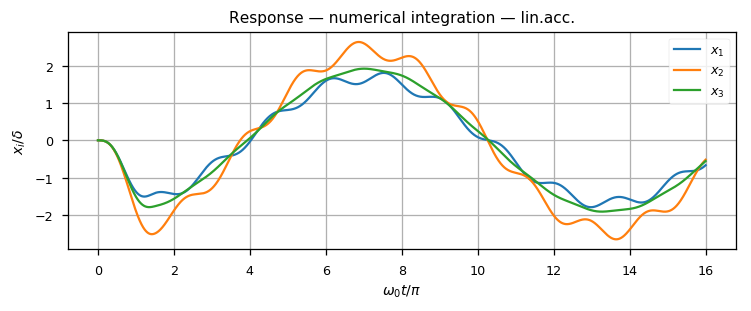

In [15]:
for i, line in enumerate(plt.plot(a/pi, Xl), 1):
    line.set_label(r'$x_{%d}$'%i)
plt.xlabel(r'$\omega_0 t/\pi$')
plt.ylabel(r'$x_i/\delta$')
plt.title('Response — numerical integration — lin.acc.')
plt.legend();

## Equation of Motion

Denoting with $\boldsymbol x$ the dynamic component of the displacements, with $\boldsymbol x_\text{tot} = \boldsymbol x + \boldsymbol x_\text{stat} = \boldsymbol x + \boldsymbol e \;u_\mathcal{A}$ the equation of motion is (the independent variable being $a=\omega_0t$)

$$ \hat{\boldsymbol M} \ddot{\boldsymbol x} + 
   \hat{\boldsymbol K} \boldsymbol x  = 
   - \hat{\boldsymbol M} \boldsymbol e \ddot u_\mathcal{A}. $$ 
   
Using mass-normalized eigenvectors, with $\boldsymbol x = \delta\boldsymbol\Psi\boldsymbol q$ we have

$$ \boldsymbol I \ddot{\boldsymbol q} + 
   \boldsymbol\Lambda^2\boldsymbol q =
   \boldsymbol\Psi^T\hat{\boldsymbol M} \boldsymbol e \frac{\ddot u_A}{\delta}.$$

It is $$\frac{\ddot u_A}{\delta} = \frac{1}{2\pi}\,\lambda_0^2\,\sin(\lambda_0a)$$

and $$ \ddot q_i + \lambda_i^2 q_i =
\frac{\Gamma_i}{2\pi}\,\lambda_0^2\,\sin(\lambda_0 a),\qquad\text{with }
\Gamma_i = -\boldsymbol\psi_i^T \hat{\boldsymbol M} \boldsymbol e\text{ and }
\lambda_0 = \frac43.$$

In [16]:
G = - Psi.T @ M @ e

Substituting a particular integral $\xi_i=C_i\sin(\lambda_0 a)$ in the
modal equation of motion we have

$$(\lambda^2_i-\lambda^2_0)\,C_i\sin(\lambda_0 a) =
  \frac{\Gamma_i}{2\pi}\,\lambda_0^2\,\sin(\lambda_0 a)$$

and solving w/r to $C_i$ we have

$$ C_i = \frac{\Gamma_i}{2\pi}\,\frac{\lambda_0^2}{\lambda_i^2-\lambda_0^2}$$

In [17]:
C = G*l0**2/(li**2-l0**2)/2/pi

The modal response, taking into account that we start from rest conditions, is

$$ q_i = C_i\left(\sin(\lambda_0 a) -
                   \frac{\lambda_0}{\lambda_i}\,\sin(\lambda_i a)\right)$$
$$ \dot q_i = \lambda_0 C_i \left(
      \cos(\lambda_0 a) - \cos(\lambda_i a) \right).$$

In [18]:
for n in range(3):
    i = n+1
    ld(r'q_%d=%+10f\left(\sin\frac43a-%10f\sin%1fa\right)' % (i,C[n],l0/li[n],li[n]),
       r'\qquad\text{for }0 \le a \le \frac32\pi')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Free vibration phase, $a\ge 3\pi/2 = a_1$

When the forced phase end, the system is in free vibrations and we can determine the constants of integration requiring that the displacements and velocities of the free vibration equal the displacements and velocities of the forced response at $t=t_0$.

\begin{align}
  + (\cos\lambda_i a_1)\, A_i + (\sin\lambda_i a_1)\, B_i &= 
  q_i(a_1) \\ 
  - (\sin\lambda_i a_1)\, A_i + (\cos\lambda_i a_1)\, B_i &= 
  \frac{\dot q_i(a_1)}{\lambda_i}
\end{align}

Because the coefficients form an othogonal matrix,

\begin{align}
  A_i &= + (\cos\lambda_i a_1)\, q_i(a_1)
         - (\sin\lambda_i a_1)\, \frac{\dot q_i(a_1)}{\lambda_i}\\
  B_i &= + (\sin\lambda_i a_1)\, q_i(a_1) 
         + (\cos\lambda_i a_1)\, \frac{\dot q_i(a_1)}{\lambda_i}.
\end{align}

In [19]:
a1 = 3*pi/2
q_a1 = C*(sin(l0*a1)-l0*sin(li*a1)/li)
v_a1 = C*l0*(cos(l0*a1)-cos(li*a1))

ABs = []
for i in range(3):
    b = array((q_a1[i], v_a1[i]/li[i]))
    A = array(((+cos(li[i]*a1), -sin(li[i]*a1)), 
               (+sin(li[i]*a1), +cos(li[i]*a1))))
    ABs.append(A@b)
ABs = array(ABs)

#### Analytical expressions

In [20]:
display(Latex(r'Modal responses for $a_1 \le a$.'))
for n in range(3):
    i, l, A_, B_ = n+1, li[n], *ABs[n]
    display(Latex((r'$$q_{%d} = '+
                  r'%+6.3f\cos%6.3fa '+
                  r'%+6.3f\sin%6.3fa$$')%(i, A_, l, B_, l)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Stitching the two responses

We must evaluate numerically the analytical responses

In [22]:
ac = a[:,None]

q = where(ac<=a1,
             C*(sin(l0*ac)-l0*sin(li*ac)/li),
             ABs[:,0]*cos(li*ac) + ABs[:,1]*sin(li*ac))

#### Plotting the Analytical Response
First, we zoom around $a_1$ to verify the continuity of displacements and velocities

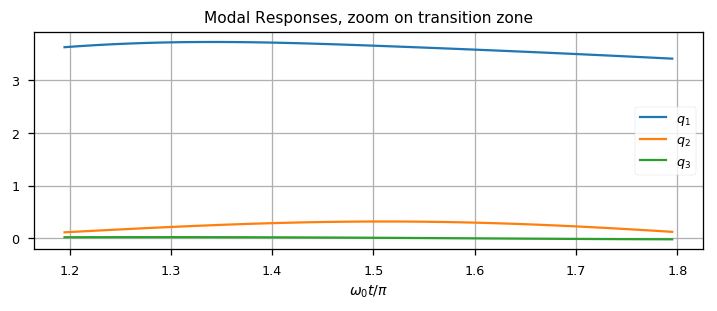

In [23]:
# #### Plot zooming around a1
low, hi = int(0.8*a1*nsppi/pi), int(1.2*a1*nsppi/pi)
for i, line in enumerate(plt.plot(a[low:hi]/pi, q[low:hi]), 1):
    line.set_label('$q_{%d}$'%i)
plt.title('Modal Responses, zoom on transition zone')
plt.xlabel(r'$\omega_0 t/\pi$')
plt.legend(loc='best')
plt.show()

next, the modal responses over the interval $0 \le a \le 16\pi$

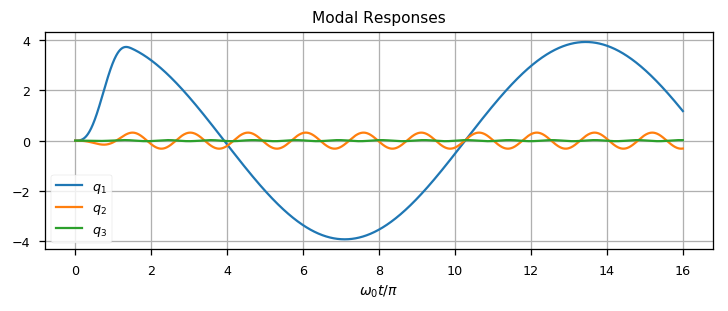

In [24]:
# #### Plot in 0 ≤ a ≤ 16 pi
for i, line in enumerate(plt.plot(a/pi, q), 1):
    line.set_label('$q_{%d}$'%i)
plt.title('Modal Responses')
plt.xlabel(r'$\omega_0 t/\pi$')
plt.legend(loc='best');
plt.xticks()
plt.show();

### Nodal responses

In [25]:
x = q@Psi.T

Why `x = q@Psi.T` rather than `x = Psi@q`?  Because for different reasons (mostly, ease of use with the plotting libraries) we have all the response arrays organized in the shape of `(Nsteps × 3)`. 

That's equivalent to say that `q` and `x`, the Pyton objects, are isomorph to $\boldsymbol q^T$ and $\boldsymbol x^T$ and because it is  $$\boldsymbol x^T = (\boldsymbol\Psi \boldsymbol q)^T = \boldsymbol q^T \boldsymbol \Psi^T,$$
in Python to write `x = q@Psi.T` we have.

That said. here are the plot of the nodal responses. Compare with the numerical solutions.

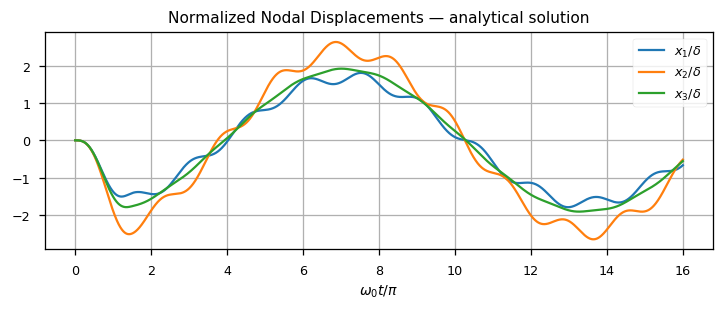

In [26]:
for i, line in enumerate(plt.plot(a/pi, x), 1):
    line.set_label('$x_{%d}/\delta$'%i)
plt.title('Normalized Nodal Displacements — analytical solution')
plt.xlabel(r'$\omega_0 t / \pi$')
plt.legend(loc='best')
plt.show();